In [1]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.linalg import norm
from joblib import Parallel, delayed
from matplotlib.colors import LogNorm, PowerNorm
from math import pi, sqrt, sin, cos, acos, atan2, tanh, exp, log, floor, hypot

In [2]:
view_length = 8
view_size = view_length / 2

absorption_cm_squared_per_g = 0.05
scattering_cm_squared_per_g = 0.05
source_function = 0
asymmetry_constant = 0.6

distance_steps = 200
theta_steps = 360
phi_steps = 72
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 66
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

In [3]:
def spherical_to_cartesian(r, theta, phi):
    sin_theta = sin(theta)
    x = r * sin_theta * cos(phi)
    y = r * sin_theta * sin(phi)
    z = r * cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = sqrt(x ** 2 + y ** 2 + z ** 2)
    if r == 0:
        return 0, 0, 0
    theta = acos(z / r)
    phi = atan2(y, x)
    return r, theta, phi

def cartesian_to_observer(x, y, z):
    u = x * cos_inc - z * sin_inc
    v = y
    w = x * sin_inc + z * cos_inc
    return u, v, w

def observer_to_cartesian(u, v, w):
    x = u * cos_inc + w * sin_inc
    y = v
    z = -u * sin_inc + w * cos_inc
    return x, y, z

def observer_to_pixels(u, v, w):
    px = int(floor((u + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
    py = int(floor((v + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
    d = int((view_length / 2 - w) / dw)
    return px, py, d

def pixels_to_observer(px, py, d):
    u = (px - ((resolution - 1) / 2)) * grid_size
    v = (py - ((resolution - 1) / 2)) * grid_size
    w = view_length / 2 - d * dw
    return u, v, w

def vector_angle(x1, y1, z1, x2, y2, z2):
    norm1 = hypot(x1, y1, z1)
    norm2 = hypot(x2, y2, z2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    dot = x1 * x2 + y1 * y2 + z1 * z2
    factor = dot / (norm1 * norm2)
    factor = max(-1, min(1, factor))
    return acos(factor)

In [4]:
def density_spherical(r, theta):
    if r <= 0.25:
        return 0
    multiplier = 1
    if r >= 4 * sin(abs(pi / 2 - theta)) ** 3 and r <= 5 * sin(abs(pi / 2 - theta)) ** 3 and r <= 3 or r >= 4 * sin(abs(pi / 2 - theta)) ** 3 and r <= 1:
        multiplier = 10
    return multiplier / r ** 2
    
    x, y, z = spherical_to_cartesian(r, theta, 0)
    return density_cartesian(x, y, z)

def density_cartesian(x, y, z):
    r, theta, _ = cartesian_to_spherical(x, y, z)
    return density_spherical(r, theta)

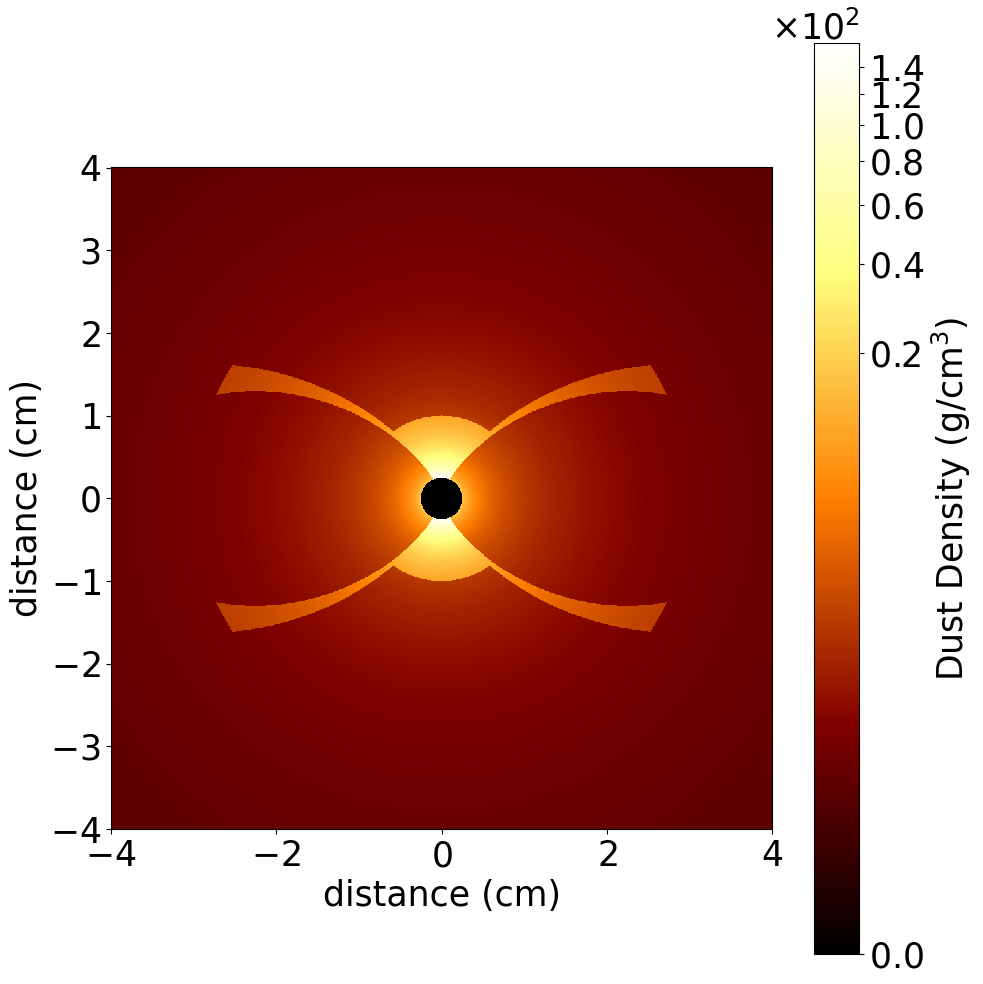

In [5]:
@np.vectorize
def density_map(x, y):
    return float(density_cartesian(0, y, -x))
# Density display

# Computing the density map
density_grid = np.linspace(-view_size, view_size, 1001)
depth_grid = np.linspace(-view_size, view_size, 1001)
density_x, density_y = np.meshgrid(density_grid, density_grid)
density_value = density_map(density_x, density_y)
min_nonzero = np.min(density_value[density_value != 0])

plt.figure(figsize = (10, 10))

import matplotlib.ticker as ticker
mesh = plt.pcolormesh(density_x, density_y, density_value, norm = PowerNorm(0.2), cmap = 'afmhot')
plt.gca().set_aspect('equal')

plt.xlabel("distance (cm)", fontsize = 25)
plt.ylabel("distance (cm)", fontsize = 25)

# plt.xticks([3e17, 2e17, 1e17, 0, -1e17, -2e17, -3e17])
# plt.yticks([3e17, 2e17, 1e17, 0, -1e17, -2e17, -3e17])

formatter = ticker.ScalarFormatter(useMathText = True)
formatter.set_powerlimits((0, 0))

plt.gcf().gca().xaxis.get_offset_text().set_fontsize(25)
plt.gcf().gca().yaxis.get_offset_text().set_fontsize(25)

plt.gcf().gca().xaxis.set_major_formatter(formatter)
plt.gcf().gca().yaxis.set_major_formatter(formatter)

cbar = plt.colorbar(mesh)
cbar.set_label('Dust Density (g/cm$^3$)', fontsize = 25)
cbar.ax.tick_params(labelsize = 25)
formatter = ticker.ScalarFormatter(useMathText = True)
formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_major_formatter(formatter)
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_size(25)

plt.tick_params(axis = 'both', which = 'both', labelsize = 25)

plt.rcParams.update({'font.size': 12})
plt.tight_layout()

# plt.savefig("density-example.png", dpi = 300)

plt.show()

In [6]:
def henyey_greenstein(angle):
    return 1 / (4 * pi) * (1 - asymmetry_constant * asymmetry_constant) / ((1 + asymmetry_constant * asymmetry_constant - 2 * asymmetry_constant * cos(angle)) ** (3 / 2))

In [7]:
def propagate_center_to_first(I, r, theta):

    for i in range(distance_substeps):
    
        k_v = (absorption_cm_squared_per_g + scattering_cm_squared_per_g) * density_spherical(r + i * ds, theta) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds + j_v * ds
        I = I + dI
    
    return I

In [8]:
def compute_one_angle(i):
    row = np.ones(distance_steps + 1)
    theta = acos(1 - i / theta_steps)
    
    for j in range(1, distance_steps + 1):
        r = j * dr
        row[j] = propagate_center_to_first(row[j - 1], r, theta)
    
    return row

def compute_spherical():
    results = Parallel(n_jobs = -1)(
        delayed(compute_one_angle)(i) 
        for i in range(theta_steps)
    )
    return np.array(results)

spherical_array = compute_spherical()

In [9]:
cubical_array = np.zeros((resolution, (resolution + 1) // 2, depth))
image_array = np.zeros((resolution, (resolution + 1) // 2, depth))

def send_photon(i, j, phi):

    r = j * dr
    theta = acos(1 - i / theta_steps)

    intensity = spherical_array[i, j]

    x, y, z = spherical_to_cartesian(r, theta, phi)
    u, v, w = cartesian_to_observer(x, y, z)
    px, py, d = observer_to_pixels(u, v, w)

    scattering_angle = vector_angle(u, v, w, 0, 0, 1)

    if px >= 0 and px < resolution and py >= 0 and py <= (resolution + 1) // 2:
        increment = intensity * (1 - exp(-dr * scattering_cm_squared_per_g * density_spherical(r, theta))) # now that the photon arrived, calculate the chance to scatter between r + dr
        cubical_array[px, py, d] += increment # reserved for further scattering
        image_array[px, py, d] += increment * henyey_greenstein(scattering_angle) # peel-off amount

    x, y, z = spherical_to_cartesian(r, pi - theta, phi)
    u, v, w = cartesian_to_observer(x, y, z)
    px, py, d = observer_to_pixels(u, v, w)

    scattering_angle = vector_angle(u, v, w, 0, 0, 1)

    if px >= 0 and px < resolution and py >= 0 and py <= (resolution + 1) // 2:
        increment = intensity * (1 - exp(-dr * scattering_cm_squared_per_g * density_spherical(r, theta)))
        cubical_array[px, py, d] += increment
        image_array[px, py, d] += increment * henyey_greenstein(scattering_angle)

for i in tqdm(range(theta_steps)):
    for j in range(1, distance_steps + 1):
        for phi in np.arange(-pi, 0, dphi):
            send_photon(i, j, phi)

image_array[(resolution - 1) // 2, (resolution - 1) // 2, (depth - 1) // 2] += theta_steps * distance_steps * phi_steps * 2

100%|█████████████████████████████████████████| 360/360 [00:15<00:00, 23.05it/s]


In [10]:
def propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps):

    x, y, z = x0, y0, z0
    
    for i in range(random_steps):

        x += random_x * ds_depth
        y += random_y * ds_depth
        z += random_z * ds_depth

        if x ** 2 + y ** 2 + z ** 2 >= view_length ** 2:
            return 0, 0, 0, 0 # photon escapes
    
        k_v = (absorption_cm_squared_per_g + scattering_cm_squared_per_g) * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds_depth + j_v * ds_depth
        I = I + dI
    
    return x, y, z, I

In [11]:
def multiple_scattering(weight, px, py, d):

    u, v, w = pixels_to_observer(px, py, d)
    x0, y0, z0 = observer_to_cartesian(u, v, w)
    
    while True:

        random_phi = 2 * pi * np.random.rand()
        random_z = 2 * np.random.rand() - 1
        random_r = sqrt(1 - random_z ** 2)
        random_x = random_r * cos(random_phi)
        random_y = random_r * sin(random_phi)

        random_steps = int(np.random.randint(depth * depth_substeps) + 1)

        I = cubical_array[px, py, d]
        scattering_angle = vector_angle(x0, y0, z0, random_x, random_y, random_z)
        I = I * henyey_greenstein(scattering_angle)

        x_dest, y_dest, z_dest, I_dest = propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps)

        if I_dest == 0:
            break

        u_dest, v_dest, w_dest = cartesian_to_observer(x_dest, y_dest, z_dest)
        px_dest, py_dest, d_dest = observer_to_pixels(u_dest, v_dest, w_dest)

        if px_dest >= 0 and px_dest < resolution and py_dest >= 0 and py_dest < (resolution + 1) // 2 and d_dest >= 0 and d_dest < depth:

            peel_off_angle = vector_angle(random_x, random_y, random_z, 0, 0, 1)
            image_array[px_dest, py_dest, d_dest] += weight * I_dest * (1 - exp(-ds_depth * scattering_cm_squared_per_g * density_cartesian(x_dest, y_dest, z_dest))) * henyey_greenstein(peel_off_angle)
        
        else:
            break

In [12]:
all_positions = [
    (px, py, d)
    for px in range(resolution)
    for py in range((resolution + 1) // 2)
    for d in range(depth)
]

ms_count = 100
ms_weight = resolution * ((resolution + 1) // 2) * depth / ms_count

sampled_positions = random.sample(all_positions, 100)

for px, py, d in tqdm(sampled_positions):
    multiple_scattering(ms_weight, px, py, d)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 405.63it/s]


In [13]:
def propagate_los(I, px, py, d):

    u, v, w = pixels_to_observer(px, py, d)
    
    for i in range(depth_substeps):
        
        x, y, z = observer_to_cartesian(u, v, w - i * ds_depth)
    
        k_v = (absorption_cm_squared_per_g + scattering_cm_squared_per_g) * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds_depth + j_v * ds_depth
        I = I + dI
    
    return I

In [14]:
for px in tqdm(range(resolution)):
    for py in range((resolution + 1) // 2):
        for d in reversed(range(depth - 1)):
            image_array[px, py, d] += propagate_los(image_array[px, py, d + 1], px, py, d)

100%|█████████████████████████████████████████| 201/201 [00:29<00:00,  6.77it/s]


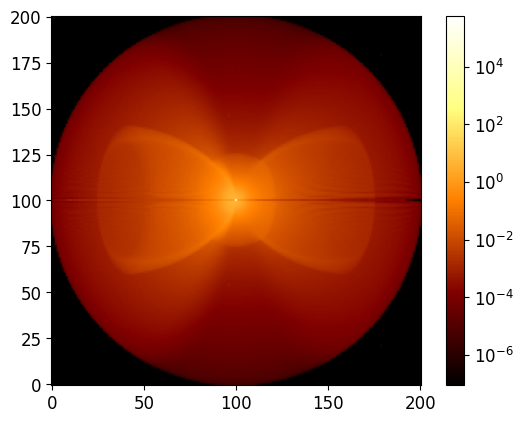

In [15]:
image = np.vstack((np.transpose(image_array[:, :, 0], (1, 0)), np.transpose(image_array[:, :, 0], (1, 0))[:-1, :][::-1, :]))

buffer = np.min(image[image > 0])
buffered_image = image.copy()
buffered_image[buffered_image <= buffer] = buffer

plt.imshow(buffered_image, origin = 'lower', cmap = 'afmhot', norm = LogNorm())
plt.colorbar()
plt.show()

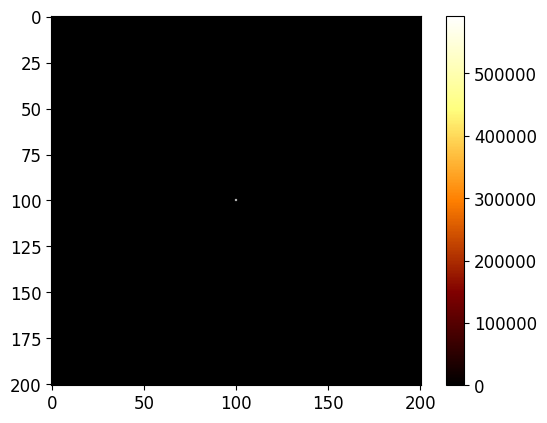

In [16]:
plt.imshow(image, cmap = 'afmhot')
plt.colorbar()

In [17]:
# END

Exception ignored in: <function ResourceTracker.__del__ at 0x106c793a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1100593a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m